## Convert Audio to image

In [160]:
import librosa.display
import librosa
import soundfile as sf
from pydub import AudioSegment

from multiprocessing import Pool
import intersection_effectivity_functions
from functools import partial

from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras_tuner.tuners import RandomSearch, Hyperband
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping

from datetime import datetime
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import Audio

import os
import shutil
import subprocess
from intersection_effectivity_functions import *


Define 4 variables containing the following paths: 
- path to the UrbanSound8k.csv file, a file containing all metadata for the dataset
- path to the unzipped keggle dataset containing 10 folders with all sound files from the dataset
- path to wav, an empty folder where the dataset created in this notebook will be stored
- path to png, an empty folder where all spectrums created later on will be stored

In [8]:
#Giacomos paths
#csv
us_file = '/Users/giacomo/Documents/lavoro/sound8k_data/UrbanSound8K.csv'
#the keggle dataset
path_keggle_dataset = '/Users/giacomo/Documents/lavoro/sound8k_data/keggle_dataset/'

#wav and png datasets
path_to_wav = '/Users/giacomo/Documents/lavoro/sound8k_data/our_dataset/'
path_to_wav_decoded = '/Users/giacomo/Documents/lavoro/sound8k_data/our_dataset_decoded/'

path_to_png = '/Users/giacomo/Documents/lavoro/sound8k_data/mel_specs/'

In [101]:

#csv
us_file = 'C:/Users/matthias/Documents/Projects/urban_sound_files/UrbanSound8K.csv'
#the keggle dataset
path_keggle_dataset = 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/'

path_to_wav = 'C:/Users/matthias/Documents/Projects/urban_sound_files/our_dataset/'
#path_to_wav_decoded = '/Users/giacomo/Documents/lavoro/sound8k_data/our_dataset_decoded/'

path_to_png = 'C:/Users/matthias/Documents/Projects/urban_sound_files/mel_specs/'

# Dataset preparation

Create a dataframe from the urban sound 8K dataset that contains all engine idling sounds as well as an equal number of random sounds taken from the other categories. 


In [102]:
df = pd.read_csv(us_file)

# create a list of all files paths from the dataset within the subfolders 
sound_files =[os.path.join(root, file) for root, directories, files in os.walk(path_keggle_dataset) for file in files]

# Create a dictionary mapping filenames to paths
file_path_dict = {os.path.basename(path): path for path in sound_files}


# Add a new column with the encoding details
df['encoding'] = df['slice_file_name'].apply(get_encoding)

# Keep only the rows with a known encoding

# keep only eingine idling values
df_engine = df.loc[(df['class'] == 'engine_idling') 
                   & (df['encoding'] != 'MS_ADPCM')
                   & (df['encoding'] != 'IMA_ADPCM')]

#pick the same amount of engine idling values from all other classes
df_non_engine = df.loc[(df['class'] != 'engine_idling')
                       & (df['encoding'] != 'MS_ADPCM')
                       & (df['encoding'] != 'IMA_ADPCM')].sample(len(df_engine), random_state=33)
# rename the different classes to non_engine_idling
df_non_engine.loc[df_non_engine['class'] != 'engine_idling', 'class'] = 'non_engine_idling'

#put the two dataframes together
df_training = pd.concat([df_non_engine, df_engine])

#create a list with all filenames from the dataframe 
file_list = df_training['slice_file_name'].tolist()

['C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/fold1\\101415-3-0-2.wav', 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/fold1\\101415-3-0-3.wav', 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/fold1\\101415-3-0-8.wav', 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/fold1\\102106-3-0-0.wav', 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/fold1\\102305-6-0-0.wav', 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/fold1\\102842-3-0-1.wav', 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/fold1\\102842-3-1-0.wav', 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/fold1\\102842-3-1-5.wav', 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/fold1\\102842-3-1-6.wav', 'C:/Users/matthias/Documents/Projects/urban_sound_files/keggel_dataset/fold1\\103074-7-0-0.wav', 'C:/Users/matthias/Documents/

In [105]:
# create a list of all files paths from the dataset within the subfolders 

sound_files =[os.path.join(root, file) for root, directories, files in os.walk(path_keggle_dataset) for file in files]


# Now copy all files present in the two lists (list of all full paths and list of files we want to use) 
# into a new folder (destination folder path defined above)

for path in sound_files:
    filename = os.path.basename(path)
    if filename in (file_list):
        destination = os.path.join(path_to_wav, filename)
        shutil.copy2(path, path_to_wav)

## Standardize imput 


Some files are recorded with one, some with two channels. Lets convert all files to two channels.
Also, some have a sampling rate of 48.000 Hz, some of 44.100 Hz. Here we need to make all imput arrays the smaller size.
Last we make all files the same length by adding silence to the end of shorter files and make them all as long as the longest file.

In [106]:

# get full path of the audio files
full_file_paths = [os.path.join(path_to_wav, filename) 
                   for filename in os.listdir(path_to_wav) 
                   if os.path.isfile(os.path.join(path_to_wav, filename))] 


In [108]:
# find max duration in ms within all audio files        
durations = []
for file in full_file_paths:
    if not file.endswith('.wav'):
        continue
    try:
        durations.append(librosa.get_duration(path=file))
    except Exception as e:
        print(f"Error with file {file}: {e}")

target_length = max(durations) * 1000 

        
# loop trough all files and apply the standardization
for file in full_file_paths:
    if not file.endswith('.wav'):
        continue
    try:
        #standardize al files to 44100 Hz and Mono as well as make them all the same length
        standardize_audio(file, target_length, samp_rate=44100, channels=True)
    except Exception as e:
        print(f"Error with file {file}: {e}")


## Data augmentation

To increase the size of our dataset we decided to augment the data we have by creating time shifted versions of our audios. 

In [109]:
# Create a new partial function with 'output_dir' pre-filled
process_file_with_output_dir = partial(augment_file, output_dir=path_to_wav)

# Create a pool of workers and apply 'process_file' function to each file
with Pool() as pool:
    pool.map(process_file_with_output_dir, full_file_paths)

## Create mel spectrograms

First we check one of the samples just to make sure everything is right. We take a look at a waveplot as well as a mel spectrogram.
After that we will create mel spectrograms for each audio file.

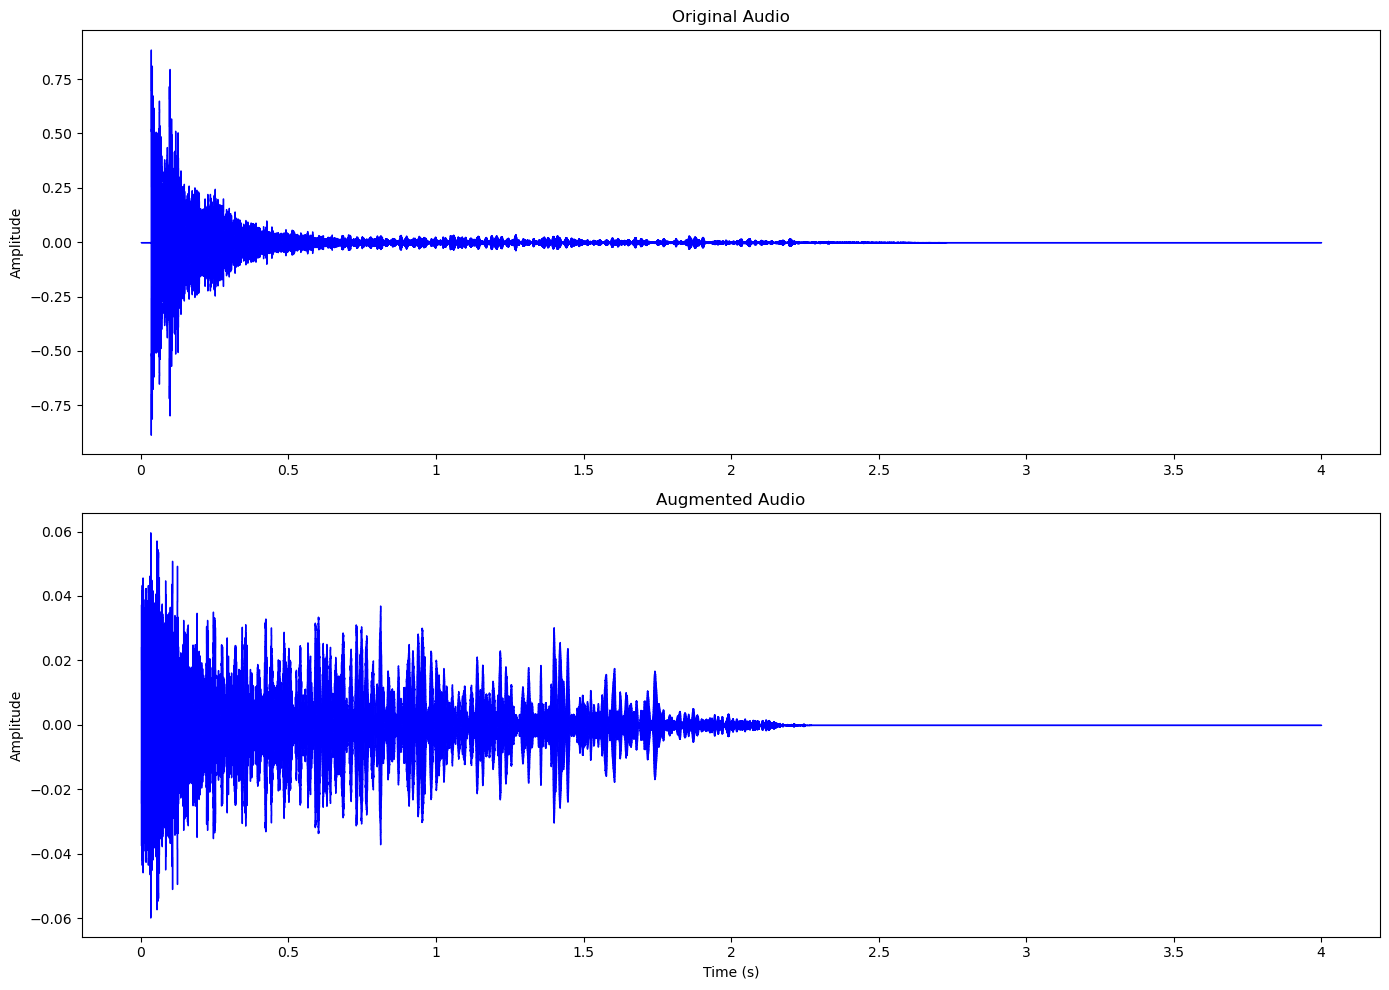

In [153]:
# select an audio file as an example as well as its augmented version to see the difference
audio_file =  path_to_wav  + '7067-6-0-0.wav'
audio_file_aug = path_to_wav + '7067-6-0-0_aug.wav'

#If samples are not already, convert to np.array, can probably be simpflified, no need for if check
y, sr = librosa.load(audio_file, sr=44100, mono = True)
y_aug, sr_aug = librosa.load(audio_file_aug, sr=44100, mono = True)



if not isinstance(y, np.ndarray):
    samples = np.array(y)


plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr, color='b') #color specification needed due to version incompatibility problems btw librosa and matplotlib
plt.title('Original Audio')
plt.xlabel('')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_aug, sr=sr_aug, color='b') #color specification needed due to version incompatibility problems btw librosa and matplotlib
plt.title('Augmented Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

In [147]:
# Listen to the audio 
Audio(audio_file)

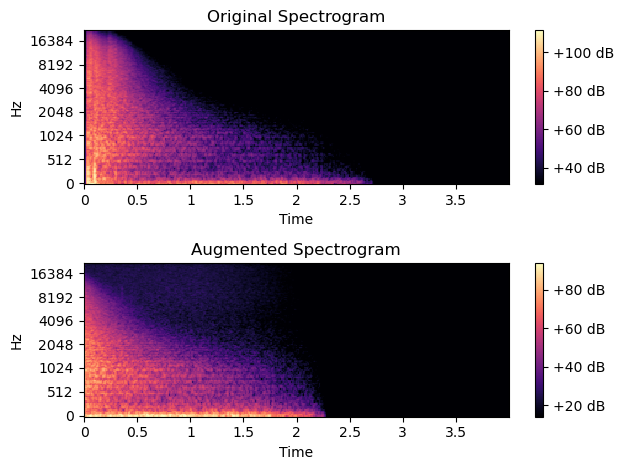

In [163]:

#Apply fourier transformation and plot 
sgram = librosa.stft(y)
sgram_aug = librosa.stft(y_aug)

# create mel spectrogram
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)

sgram_mag_aug, _ = librosa.magphase(sgram_aug)
mel_scale_sgram_aug = librosa.feature.melspectrogram(S=sgram_mag_aug, sr=sr_aug)

mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)

mel_sgram_aug = librosa.amplitude_to_db(mel_scale_sgram_aug, ref=np.min)



plt.subplot(2, 1, 1)
librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Spectrogram')

# Plot the second spectrogram
plt.subplot(2, 1, 2)
librosa.display.specshow(mel_sgram_aug, sr=sr_aug, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Augmented Spectrogram')

# Adjust layout for better appearance
plt.tight_layout()

# Show the plots
plt.show()

In [114]:
# create mel specs for all audio files in the dataset
create_mel_specs(path_to_wav, path_to_png)

Before creating the NN we need to add the augmented files to the pandas dataframe created at the beginning.

In [155]:
# We now want to add the augmented files to this dataframe. In order to attach the correct label to them
# we concatenate two identical dataframes, with one having the .wav ending and the other the _aug.wav ending. 
# This way we assign the correct labels to the _aug.wav files

def add_augmentation(row):
    row['slice_file_name'] = row['slice_file_name'].replace('.wav', '_aug.wav')
    return row


# Apply the function and concatenate the results
df_train_augmented = pd.concat([df_training, df_training.apply(add_augmentation, axis=1)], ignore_index=True)


print(df_train_augmented['class'].value_counts())

class
non_engine_idling    2000
engine_idling        2000
Name: count, dtype: int64


# Create NNs

In [156]:


# Preprocess and batch the dataset (add any necessary preprocessing here)
df_train_augmented.loc[:,'slice_file_name'] = df_train_augmented['slice_file_name'].str.replace('.wav', '.png')


# Split the data into train+validation and test sets
train_val_df, test_df = train_test_split(df_train_augmented, test_size=0.2, random_state=42)

# Further split the train+validation set into separate train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create an ImageDataGenerator for data loading and preprocessing
datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to the range [0, 1]
)

# Use flow_from_dataframe to load and preprocess the images
batch_size = 128  # Adjust this according to your needs

# Train generator
train_generator = datagen.flow_from_dataframe(
    train_df,
    directory=path_to_png,
    x_col="slice_file_name",  # Column containing filenames
    y_col="class",  # Column containing class labels
    target_size=(224, 224),  # Reshape your images to a desired size
    batch_size=batch_size,
    class_mode='categorical',  # If you have multiple classes
    validate_filenames=False  # For the training set
)

# Validation generator
validation_generator = datagen.flow_from_dataframe(
    val_df,
    directory=path_to_png,
    x_col="slice_file_name",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    validate_filenames=False # For the validation set
)

# Test generator
test_generator = datagen.flow_from_dataframe(
    test_df,
    directory=path_to_png,
    x_col="slice_file_name",
    y_col="class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    validate_filenames=False # For the test set
)

num_classes = len(train_generator.class_indices)  # Get the number of classes

Found 2400 non-validated image filenames belonging to 2 classes.
Found 800 non-validated image filenames belonging to 2 classes.
Found 800 non-validated image filenames belonging to 2 classes.


In [161]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1_filter', min_value=16, max_value=32, step=16), (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.1, default=0.05, step=0.05)))

    model.add(Conv2D(hp.Int('conv_2_filter', min_value=32, max_value=64, step=32), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Conv2D(hp.Int('conv_3_filter', min_value=64, max_value=128, step=32), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Conv2D(hp.Int('conv_4_filter', min_value=128, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Conv2D(hp.Int('conv_5_filter', min_value=256, max_value=512, step=128), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_5', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Flatten())

    model.add(Dense(units=hp.Int('dense_1_units', min_value=128, max_value=256, step=64),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_dense_1', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Dense(units=hp.Int('dense_2_units', min_value=256, max_value=512, step=128),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_dense_2', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Dense(2, activation='softmax'))
    
    optimizer = Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'),
        decay=hp.Float('decay', min_value=1e-6, max_value=1e-2, sampling='LOG'),
        beta_1=0.9,
        beta_2=0.999
    )

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    directory='tuner_results',
    project_name='engine_idling'
)

tuner.search_space_summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)
 
tuner.results_summary()

Trial 30 Complete [00h 09m 37s]
val_accuracy: 0.5762500166893005

Best val_accuracy So Far: 0.9474999904632568
Total elapsed time: 04h 16m 16s
Results summary
Results in tuner_results\engine_idling
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0024 summary
Hyperparameters:
conv_1_filter: 16
dropout_1: 0.1
conv_2_filter: 32
dropout_2: 0.2
conv_3_filter: 128
dropout_3: 0.30000000000000004
conv_4_filter: 128
dropout_4: 0.1
conv_5_filter: 384
dropout_5: 0.30000000000000004
dense_1_units: 128
dropout_dense_1: 0.1
dense_2_units: 384
dropout_dense_2: 0.2
learning_rate: 0.0006651033679993193
decay: 1.9813992745897525e-06
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.9474999904632568

Trial 0025 summary
Hyperparameters:
conv_1_filter: 16
dropout_1: 0.1
conv_2_filter: 64
dropout_2: 0.30000000000000004
conv_3_filter: 128
dropout_3: 0.2
conv_4_filter: 256
dropout_4: 0.1
conv_5_filter: 512
dropout_5: 0.4
dense_1

In [ ]:

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1_filter', min_value=16, max_value=32, step=16), (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.1, default=0.05, step=0.05)))

    model.add(Conv2D(hp.Int('conv_2_filter', min_value=32, max_value=64, step=32), (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Conv2D(hp.Int('conv_3_filter', min_value=64, max_value=128, step=32), (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Conv2D(hp.Int('conv_4_filter', min_value=128, max_value=256, step=64), (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Conv2D(hp.Int('conv_5_filter', min_value=256, max_value=512, step=128), (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Flatten())

    model.add(Dense(units=hp.Int('dense_1_units', min_value=128, max_value=256, step=64),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_dense_1', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Dense(units=hp.Int('dense_2_units', min_value=256, max_value=512, step=128),
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_dense_2', min_value=0.1, max_value=0.4, default=0.25, step=0.1)))

    model.add(Dense(2, activation='softmax'))
    
    optimizer = Adam(lr=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]), decay=1e-6, beta_1=0.9, beta_2=0.999)

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

tuner.search_space_summary()

tuner.search(train_generator, epochs=20, validation_data=validation_generator)

tuner.results_summary()

In [15]:

def build_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='leaky_relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0))

    model.add(Conv2D(128, (3, 3), activation='leaky_relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(256, (3, 3), activation='leaky_relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(512, (3, 3), activation='leaky_relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    
    model.add(Dense(512, activation='leaky_relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='leaky_relu'))
    model.add(Dropout(0.2)) 
    
    model.add(Dense(2, activation='softmax'))
    optimizer = Adam(lr=0.001, decay=1e-6, beta_1=0.9, beta_2=0.999)

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    

    return model


model = build_model()


# Get the current time
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

# Save the model architecture
model_json = model.to_json()
with open(f"model_{timestamp}.json", "w") as json_file:
    json_file.write(model_json)

# Save the learning rate
with open(f"learning_rate_{timestamp}.txt", "w") as lr_file:
    lr_file.write(str(0.01))  # Replace with your learning rate

# Train the model
history = model.fit(train_generator, epochs=20, validation_data=validation_generator)

# Save the training results
with open(f'history_{timestamp}.pickle', 'wb') as history_file:
    pickle.dump(history.history, history_file)


c:\Users\matthias\miniconda3\envs\thunder4\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
19/19 [==============================] - 470s 23s/step - loss: 0.8728 - accuracy: 0.4971 - val_loss: 0.7088 - val_accuracy: 0.5993
Epoch 2/20
19/19 [==============================] - 434s 23s/step - loss: 0.6927 - accuracy: 0.5467 - val_loss: 0.6729 - val_accuracy: 0.5347
Epoch 3/20
19/19 [==============================] - 432s 23s/step - loss: 0.6527 - accuracy: 0.5769 - val_loss: 0.6474 - val_accuracy: 0.6017
Epoch 4/20
19/19 [==============================] - 426s 22s/step - loss: 0.6498 - accuracy: 0.6034 - val_loss: 0.6395 - val_accuracy: 0.6154
Epoch 5/20
19/19 [==============================] - 428s 22s/step - loss: 0.6286 - accuracy: 0.6199 - val_loss: 0.5900 - val_accuracy: 0.6824
Epoch 6/20
19/19 [==============================] - 412s 22s/step - loss: 0.5705 - accuracy: 0.6878 - val_loss: 0.5656 - val_accuracy: 0.6489
Epoch 7/20
19/19 [==============================] - 423s 22s/step - loss: 0.4954 - accuracy: 0.7283 - val_loss: 0.4566 - val_accuracy: 0.7630
Epoch 

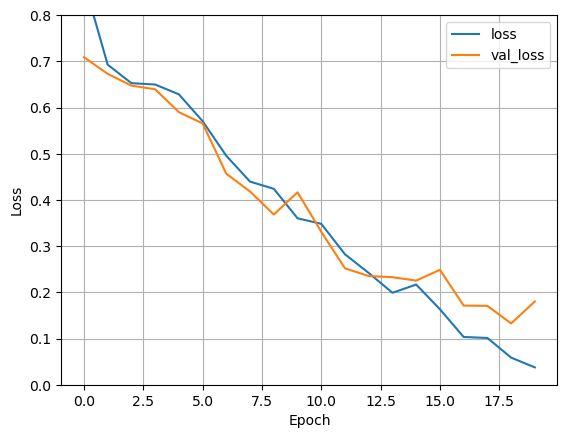

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.8])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
# launch tensorboard
%load_ext tensorboard
%tensorboard --logdir logs/fit


In [13]:
# setup tensorboard
root_logdir = os.path.join(os.curdir, 'logs')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/', histogram_freq=1)



In [14]:
# launch tensorboard
%load_ext tensorboard
%tensorboard --logdir logs/fit
